In [21]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import wave
import pylab
from pathlib import Path
from scipy import signal
from scipy.io import wavfile
from sklearn.metrics import confusion_matrix
import itertools

from keras.models import Sequential
from tensorflow.keras.layers import Dense, MaxPooling2D,Conv2D,Input,UpSampling2D, Flatten, Reshape


In [13]:
# Declare constants
IMAGE_HEIGHT = 217
IMAGE_WIDTH = 334
BATCH_SIZE = 32
N_CHANNELS = 3
spectograms = "/home/iotg/work/SWA/SWA/data/mimii-anomaly-detection/dataset_cnn/6db"

# Make a dataset containing the training spectrograms
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
                                             batch_size=BATCH_SIZE,
                                             validation_split=0.2,
                                             directory=spectograms,
                                             shuffle=True,
                                             labels="inferred",
                                             label_mode="binary",
                                             color_mode='rgb',
                                             image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
                                             subset="training",
                                             seed=42)

# # Make a dataset containing the validation spectrogram
valid_dataset = tf.keras.preprocessing.image_dataset_from_directory(
                                             batch_size=BATCH_SIZE,
                                             validation_split=0.2,
                                             directory=spectograms,
                                             shuffle=True,
                                             labels="inferred",
                                             label_mode="binary",
                                             color_mode='rgb',
                                             image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
                                             subset="validation",
                                             seed=42)

Found 2950 files belonging to 2 classes.
Using 2360 files for training.
Found 2950 files belonging to 2 classes.
Using 590 files for validation.


In [14]:
valid_dataset

<BatchDataset element_spec=(TensorSpec(shape=(None, 217, 334, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))>

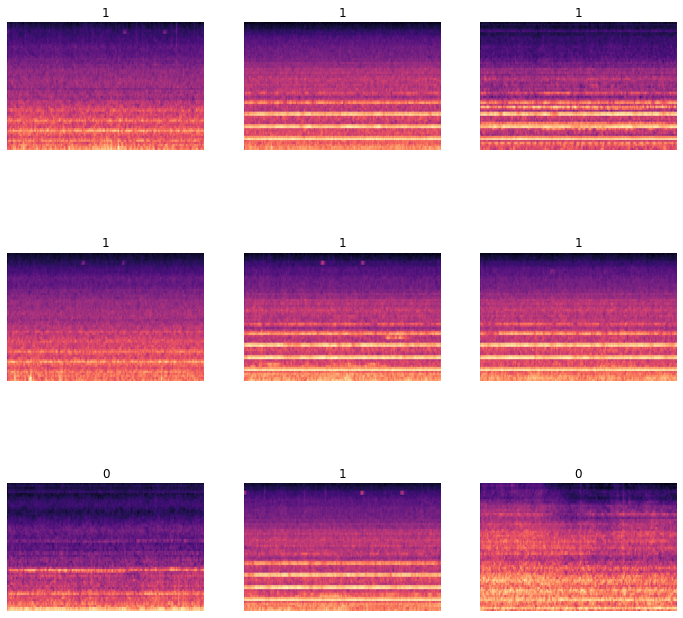

In [15]:
plt.figure(figsize=(12, 12))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")
plt.show()

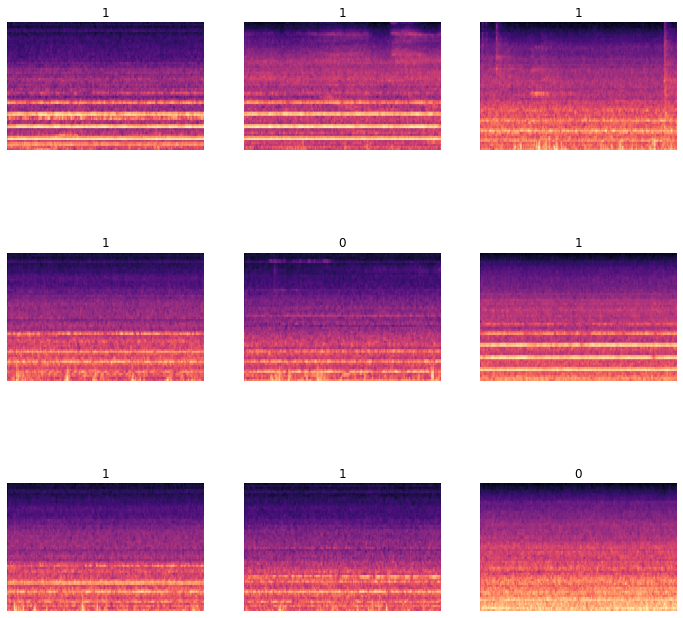

In [16]:
plt.figure(figsize=(12, 12))
for images, labels in valid_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")
plt.show()

In [17]:
# Function to prepare our datasets for modelling
def prepare(ds, augment=False):
    # Define our one transformation
    rescale = tf.keras.Sequential([tf.keras.layers.experimental.preprocessing.Rescaling(1./255)])
    flip_and_rotate = tf.keras.Sequential([
        tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
        tf.keras.layers.experimental.preprocessing.RandomRotation(0.2)
    ])
    
    # Apply rescale to both datasets and augmentation only to training
    ds = ds.map(lambda x, y: (rescale(x, training=True), y))
    if augment: ds = ds.map(lambda x, y: (flip_and_rotate(x, training=True), y))
    return ds

train_dataset = prepare(train_dataset, augment=False)
valid_dataset = prepare(valid_dataset, augment=False)

In [8]:
N_CLASSES = 2
# Create CNN model
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, N_CHANNELS)))
model.add(tf.keras.layers.Conv2D(32, 3, strides=2, padding='same', activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.BatchNormalization())
# model.add(tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'))
# model.add(tf.keras.layers.BatchNormalization())
# model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
# model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(1, activation="sigmoid"))

In [22]:
# Initialising the CNN
classifier = Sequential()

# Step 1 - Convolution
classifier.add(Conv2D(32, (3, 3), input_shape = (IMAGE_HEIGHT, IMAGE_WIDTH, 3), activation = 'relu'))

# Step 2 - Pooling
classifier.add(MaxPooling2D(pool_size = (2, 2)))

# Adding a second convolutional layer
classifier.add(Conv2D(64, (3, 3), activation = 'relu'))
classifier.add(MaxPooling2D(pool_size = (2, 2)))

# Adding a third convolutional layer
classifier.add(Conv2D(128, (3, 3), activation = 'relu'))
classifier.add(MaxPooling2D(pool_size = (2, 2)))

# Adding a fourth convolutional layer
classifier.add(Conv2D(128, (3, 3), activation = 'relu'))
classifier.add(MaxPooling2D(pool_size = (2, 2)))

# Step 3 - Flattening
classifier.add(Flatten())

# Step 4 - Full connection
classifier.add(Dense(units = 64, activation = 'relu'))
classifier.add(Dense(units = 1, activation = 'sigmoid'))

# Compiling the CNN
classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [23]:
# Compile model
classifier.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.RMSprop(),
    metrics=['accuracy'],
)

In [25]:
# Train model for 10 epochs, capture the history
history = classifier.fit(train_dataset, epochs=5, validation_data=valid_dataset)

Epoch 1/5
74/74 [==============================] - 48s 634ms/step - loss: 0.6440 - accuracy: 0.6877 - val_loss: 0.2744 - val_accuracy: 0.9102
Epoch 2/5
74/74 [==============================] - 46s 622ms/step - loss: 0.1883 - accuracy: 0.9483 - val_loss: 0.0283 - val_accuracy: 0.9915
Epoch 3/5
74/74 [==============================] - 46s 615ms/step - loss: 0.0859 - accuracy: 0.9805 - val_loss: 0.0310 - val_accuracy: 0.9932
Epoch 4/5
74/74 [==============================] - 46s 616ms/step - loss: 0.0827 - accuracy: 0.9784 - val_loss: 0.0157 - val_accuracy: 0.9966
Epoch 5/5
74/74 [==============================] - 46s 618ms/step - loss: 0.0436 - accuracy: 0.9886 - val_loss: 0.0044 - val_accuracy: 0.9966


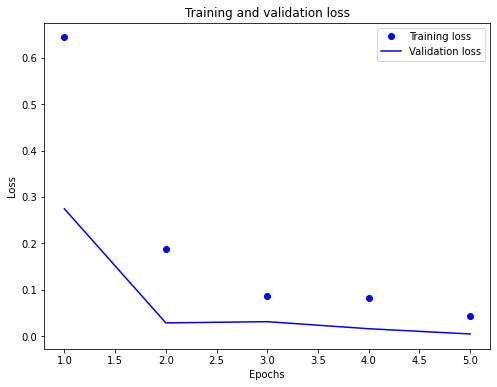

In [26]:
# Plot the loss curves for training and validation.
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values)+1)

plt.figure(figsize=(8,6))
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

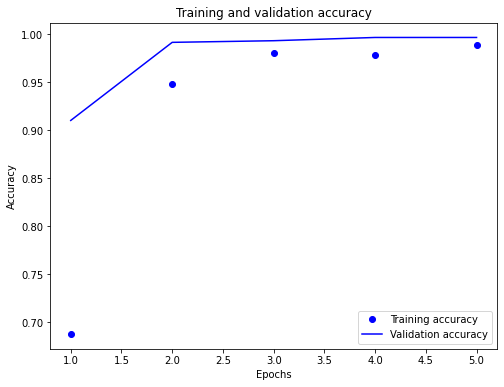

In [27]:
# Plot the accuracy curves for training and validation.
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
epochs = range(1, len(acc_values)+1)

plt.figure(figsize=(8,6))
plt.plot(epochs, acc_values, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc_values, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [28]:
# Compute the final loss and accuracy
final_loss, final_acc = classifier.evaluate(valid_dataset, verbose=0)
print("Final loss: {0:.6f}, final accuracy: {1:.6f}".format(final_loss, final_acc))

Final loss: 0.004426, final accuracy: 0.996610


In [30]:
%%time
loss, accuracy, precision, recall, f1 = classifier.evaluate(valid_dataset, verbose=2)

19/19 - 2s - loss: 0.0044 - accuracy: 0.9966 - 2s/epoch - 107ms/step


ValueError: not enough values to unpack (expected 5, got 2)

In [ ]:
metrics=['acc',keras.metrics.Precision(), keras.metrics.Recall(), get_f1]

In [32]:
for images, labels in train_dataset.take(1):  # only take first element of dataset
    numpy_images = images.numpy()
    numpy_labels = labels.numpy()

In [35]:
len(numpy_images), numpy_images.shape, len(numpy_labels), numpy_labels.shape

(32, (32, 217, 334, 3), 32, (32, 1))

In [36]:
np.unique(numpy_labels, return_counts=True)

(array([0., 1.], dtype=float32), array([16, 16]))

In [37]:
predicted_classes = classifier.predict(numpy_images)

1/1 [==============================] - 0s 184ms/step


In [47]:
# predicted_classes_2 = (np.round(predicted_classes))

In [49]:
predicted_classes_2 == numpy_labels

array([[ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True]])

In [43]:
numpy_labels[:10]

array([[0.],
       [0.],
       [0.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [0.],
       [1.]], dtype=float32)

In [50]:
classifier.save('/home/iotg/work/SWA/SWA/models/cnn_asd_classifier.h5')